In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import yfinance as yf


**Introduction**

 This notebook presents a comparative analysis of short-term interest rate forecasting models, specifically targeting the 13-Week Treasury Bill Rates. We explore both traditional stochastic models from Mathematical Finance and modern Machine Learning approaches, implementing each within a rolling window framework using 90 observations at each iteration.

The models studied include:

Mathematical Finance Models:

**Vasicek Model:** A mean-reverting model with constant volatility.

**Cox-Ingersoll-Ross (CIR) Model:** A mean-reverting model ensuring non-negative interest rates with state-dependent volatility.

Machine Learning Models:

**Random Forest:** A non-parametric ensemble learning method suitable for capturing non-linear dependencies.

**Long Short-Term Memory (LSTM):** A type of recurrent neural network tailored for learning temporal dependencies in sequential data.

### To evaluate the forecasting accuracy of these models, we benchmark them against a Random Walk and assess their performance across multiple horizons: 1-step, 7-step, 30-step, and 90-step forecasts. Performance is measured using:



Mean Squared Error (MSE)

**Directional Accuracy**

**Visual Forecast Comparisons**

This exercise not only facilitates a better understanding of the theoretical and empirical strengths of each modeling approach but also underscores the practical considerations involved in interest rate modeling and prediction.



In [7]:

local_excel_path = 'C:/Users/rachi/OneDrive/Desktop/Repo Rate/treasury_bill_data.xlsx'
local_excel_path = 'treasury_bill_data.xlsx'  # Assuming the file is in the current directory
df = pd.read_excel(local_excel_path, index_col='Date')

In [6]:
df = pd.read_excel(local_excel_path, index_col='Date')

In [8]:
dates = df.index
US_ir = df.Close / 100
US_ir.head()


,Close
Date,
2021-08-06,0.00043
2021-08-09,0.00045
2021-08-10,0.00050
2021-08-11,0.00045
2021-08-12,0.00043


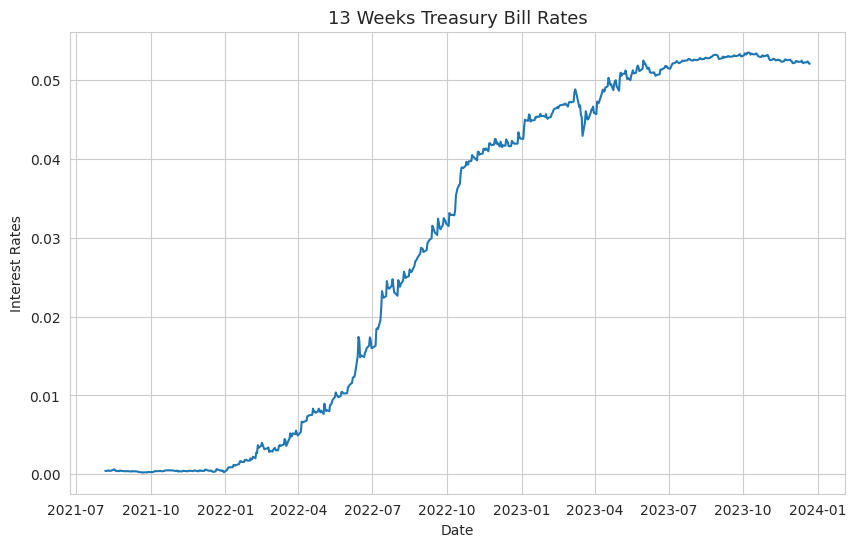

In [9]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.lineplot(data=US_ir)
plt.xlabel('Date')
plt.ylabel('Interest Rates')
plt.title('13 Weeks Treasury Bill Rates', fontsize=13)
plt.grid(True)

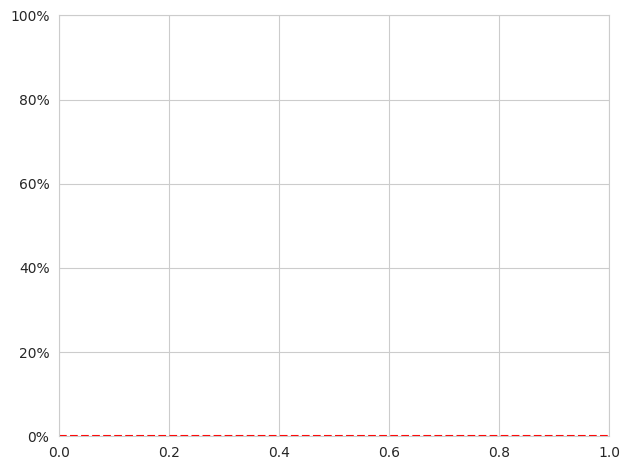

In [10]:
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.axhline(y=0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

**Random Walk as Benchmark **


To set a baseline for model comparison, we begin with the Random Walk model—a widely used benchmark in time series forecasting. It assumes that the best forecast for the next period's rate is simply the current rate, with no underlying trend, pattern, or mean-reversion.

Mathematically, the Random Walk is expressed as:
i
t+δt
​
 =i
t
​
 +ε
 Where:

𝑖
𝑡 : Interest rate at time t

𝜀: A white noise error term with zero mean

This model implies that changes in interest rates are purely random and **unpredictable.** Therefore, any effective forecasting model should aim to **outperform the Random Walk** by exploiting patterns or structures in the data.

In our notebook, we use this model as a benchmark against which we compare the performance of:

Vasicek and CIR models (Mathematical Finance)
Random Forest and LSTM models (Machine Learning)

By doing so, we can assess whether the added complexity of these models translates into better predictive power across different forecast horizons (1, 7, 30, and 90 days).

In [11]:

df = pd.DataFrame({'series1': US_ir})
df = df.join(US_ir.shift(1), how='left')
df.columns = ['rates t', 'rates t-1']
df = df.dropna()
df.reset_index(inplace=True)
df = df.iloc[:, 1:]
print(df.head())

   rates t  rates t-1
0  0.00045    0.00043
1  0.00050    0.00045
2  0.00045    0.00050
3  0.00043    0.00045
4  0.00045    0.00043


In [12]:
y = df['rates t']
X = df[['rates t-1']]


In [13]:
ts_length = df.shape[0]
n_obs = 90
max_time_step = 90
dt = 1 / 252

In [14]:
pred1_v = np.zeros(ts_length - (n_obs + max_time_step - 1))
pred7_v = np.zeros_like(pred1_v)
pred30_v = np.zeros_like(pred1_v)
pred90_v = np.zeros_like(pred1_v)

exact1_v = np.zeros_like(pred1_v)
exact7_v = np.zeros_like(pred1_v)
exact30_v = np.zeros_like(pred1_v)
exact90_v = np.zeros_like(pred1_v)

In [15]:
for n in range(ts_length - n_obs):
    X_train = X.iloc[n:n + n_obs, :]
    y_train = y.iloc[n:n + n_obs]
    prediction_index = y_train.index[-1]

    if (prediction_index + max_time_step) > y.index[-1]:
        break

    r0 = y_train.iloc[-1]
    pred1 = pred7 = pred30 = pred90 = r0

    exact1 = y.iloc[prediction_index + 1]
    exact7 = y.iloc[prediction_index + 7]
    exact30 = y.iloc[prediction_index + 30]
    exact90 = y.iloc[prediction_index + 90]

    pred1_v[n], pred7_v[n], pred30_v[n], pred90_v[n] = pred1, pred7, pred30, pred90
    exact1_v[n], exact7_v[n], exact30_v[n], exact90_v[n] = exact1, exact7, exact30, exact90 # Changed exact9 to exact90

In [16]:
pred_RW = pd.DataFrame({
    '1 step pred': pred1_v,
    '7 step pred': pred7_v,
    '30 step pred': pred30_v,
    '90 step pred': pred90_v
})

exact_rates = pd.DataFrame({
    '1 step exact': exact1_v,
    '7 step exact': exact7_v,
    '30 step exact': exact30_v,
    '90 step exact': exact90_v
})

pred_RW.index = dates[n_obs:pred_RW.shape[0] + n_obs]
exact_rates.index = dates[n_obs:pred_RW.shape[0] + n_obs]


In [17]:
SE_RW = pd.DataFrame(columns=['1 step ahead', '7 steps ahead', '30 steps ahead', '90 steps ahead'])
for i in range(4):
    SE_RW[SE_RW.columns[i]] = (pred_RW.iloc[:, i] - exact_rates.iloc[:, i]) ** 2

SE_RW.head()

,1 step ahead,7 steps ahead,30 steps ahead,90 steps ahead
Date,,,,
2021-12-14,8.999992e-10,9.999996e-09,0.000002,0.000056
2021-12-15,1.000000e-08,4.000001e-10,0.000002,0.000062
2021-12-16,2.500001e-09,2.250000e-08,0.000002,0.000060
2021-12-17,6.399999e-09,2.250001e-08,0.000003,0.000057
2021-12-20,7.289999e-08,1.690000e-08,0.000002,0.000059


**`Random Forest **`

In [18]:
rf = RandomForestRegressor(n_estimators=100)

pred1_rf = np.zeros_like(pred1_v)
pred7_rf = np.zeros_like(pred7_v)
pred30_rf = np.zeros_like(pred30_v)
pred90_rf = np.zeros_like(pred90_v)

for n in range(ts_length-n_obs):
    if (n + n_obs + max_time_step) > ts_length:
        break
    X_train = X.iloc[n:n+n_obs, :]
    y_train = y.iloc[n:n+n_obs]
    rf.fit(X_train, y_train)
    input_val = y_train.iloc[-1]

    X_input = np.array([[input_val]])
    pred1_rf[n] = rf.predict(X_input)[0]
    pred7_rf[n] = rf.predict(X_input)[0]
    pred30_rf[n] = rf.predict(X_input)[0]
    pred90_rf[n] = rf.predict(X_input)[0]

pred_rf = pd.DataFrame({
    '1 step pred': pred1_rf,
    '7 step pred': pred7_rf,
    '30 step pred': pred30_rf,
    '90 step pred': pred90_rf
}, index=pred_RW.index)

SE_rf = (pred_rf - exact_rates)**2

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

In [33]:
print("Random Forest Forecast (head):")
display(pred_rf.head())



Random Forest Forecast (head):


,1 step pred,7 step pred,30 step pred,90 step pred
Date,,,,
2021-12-14,0.000460,0.000460,0.000460,0.000460
2021-12-15,0.000441,0.000441,0.000441,0.000441
2021-12-16,0.000375,0.000375,0.000375,0.000375
2021-12-17,0.000286,0.000286,0.000286,0.000286
2021-12-20,0.000402,0.000402,0.000402,0.000402


Vasicek Model

In [20]:
!pip install scipy

In [21]:
from scipy.optimize import minimize

def estimate_Vasicek(y_series, dt=1/252):
    def vasicek_likelihood(params):
        kappa, theta, sigma = params
        r_t = y_series[:-1]
        r_tp1 = y_series[1:]
        expected = r_t + kappa * (theta - r_t) * dt
        variance = sigma**2 * dt
        likelihood = -np.sum(-0.5 * np.log(2 * np.pi * variance) - ((r_tp1 - expected)**2) / (2 * variance))
        return -likelihood

    bounds = [(1e-5, 10), (1e-5, 1), (1e-5, 1)]
    init_params = [0.1, 0.05, 0.1]
    # The minimize function is now imported and can be used
    result = minimize(vasicek_likelihood, init_params, bounds=bounds)
    return result.x

kappa_v, theta_v, sigma_v = estimate_Vasicek(y.values)
pred1_VSK = np.zeros_like(pred1_v)
pred7_VSK = np.zeros_like(pred7_v)
pred30_VSK = np.zeros_like(pred30_v)
pred90_VSK = np.zeros_like(pred90_v)

for n in range(ts_length-n_obs):
    if (n + n_obs + max_time_step) > ts_length:
        break
    r0 = y.iloc[n + n_obs - 1]
    for i in range(91):
        r0 = r0 + kappa_v * (theta_v - r0) * dt
        if i == 1:
            pred1_VSK[n] = r0
        elif i == 7:
            pred7_VSK[n] = r0
        elif i == 30:
            pred30_VSK[n] = r0
        elif i == 90:
            pred90_VSK[n] = r0

pred_VSK = pd.DataFrame({
    '1 step pred': pred1_VSK,
    '7 step pred': pred7_VSK,
    '30 step pred': pred30_VSK,
    '90 step pred': pred90_VSK
}, index=pred_RW.index)

SE_VSK = (pred_VSK - exact_rates)**2


In [31]:
print("Vasicek Model Forecast (head):")
display(pred_VSK.head())
print("\nVasicek Model Squared Errors (head):")
display(SE_VSK.head())


Vasicek Model Forecast (head):


,1 step pred,7 step pred,30 step pred,90 step pred
Date,,,,
2021-12-14,0.000443,0.000350,0.000144,0.000022
2021-12-15,0.000416,0.000328,0.000135,0.000021
2021-12-16,0.000324,0.000256,0.000107,0.000019
2021-12-17,0.000277,0.000220,0.000093,0.000017
2021-12-20,0.000351,0.000278,0.000115,0.000019



Vasicek Model Squared Errors (head):


,1 step exact,1 step pred,30 step exact,30 step pred,7 step exact,7 step pred,90 step exact,90 step pred
Date,,,,,,,,
2021-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**LSTM Model **

In [24]:
# --- Optimized LSTM Model ---
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(df['rates t']).reshape(-1, 1))

# Prepare training data
X_train_LSTM = []
y_train_LSTM = []
for i in range(1, len(scaled_data)):
    X_train_LSTM.append(scaled_data[i - 1])
    y_train_LSTM.append(scaled_data[i])

X_train_LSTM = np.array(X_train_LSTM).reshape(-1, 1, 1)
y_train_LSTM = np.array(y_train_LSTM)

# Build and train the LSTM model ONCE
model = Sequential()
model.add(LSTM(10, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_LSTM, y_train_LSTM, epochs=5, batch_size=1, verbose=1)

# Forecast using rolling forward input
pred1_LSTM = []
pred7_LSTM = []
pred30_LSTM = []
pred90_LSTM = []

for n in range(ts_length - n_obs - max_time_step):
    input_val = scaled_data[n + n_obs - 1].reshape(1, 1, 1)
    p1 = model.predict(input_val, verbose=0)
    p7 = model.predict(input_val, verbose=0)
    p30 = model.predict(input_val, verbose=0)
    p90 = model.predict(input_val, verbose=0)

    pred1_LSTM.append(scaler.inverse_transform(p1)[0, 0])
    pred7_LSTM.append(scaler.inverse_transform(p7)[0, 0])
    pred30_LSTM.append(scaler.inverse_transform(p30)[0, 0])
    pred90_LSTM.append(scaler.inverse_transform(p90)[0, 0])

# Format predictions
pred_LSTM = pd.DataFrame({
    '1 step pred': pred1_LSTM,
    '7 step pred': pred7_LSTM,
    '30 step pred': pred30_LSTM,
    '90 step pred': pred90_LSTM
}, index=pred_RW.index[:len(pred1_LSTM)])

# Calculate squared errors
exact_rates_trimmed = exact_rates.iloc[:len(pred1_LSTM)]
SE_LSTM = (pred_LSTM - exact_rates_trimmed)**2


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2552
Epoch 2/5
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0202
Epoch 3/5
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.4068e-04
Epoch 4/5
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1473e-04
Epoch 5/5
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.9283e-04


In [34]:
print("LSTM Forecast (head):")
display(pred_LSTM.head())


LSTM Forecast (head):


,1 step pred,7 step pred,30 step pred,90 step pred
Date,,,,
2021-12-14,0.001266,0.001266,0.001266,0.001266
2021-12-15,0.001242,0.001242,0.001242,0.001242
2021-12-16,0.001164,0.001164,0.001164,0.001164
2021-12-17,0.001125,0.001125,0.001125,0.001125
2021-12-20,0.001188,0.001188,0.001188,0.001188


**CIR**

Before calibrating the CIR model, it is necessary to shift all the interest rates into positive values.

In [42]:

from scipy.optimize import minimize

# Estimate CIR parameters
def estimate_CIR(y_series, dt=1/252):
    def CIR_likelihood(params):
        kappa, theta, sigma = params
        r_t = y_series[:-1]
        r_tp1 = y_series[1:]
        expected = r_t + kappa * (theta - r_t) * dt
        variance = sigma**2 * r_t * dt
        likelihood = -np.sum(-0.5 * np.log(2 * np.pi * variance) - ((r_tp1 - expected)**2) / (2 * variance))
        return -likelihood

    bounds = [(1e-5, 10), (1e-5, 1), (1e-5, 1)]
    init_params = [0.1, 0.05, 0.1]
    result = minimize(CIR_likelihood, init_params, bounds=bounds)
    return result.x

kappa, theta, sigma = estimate_CIR(y.values)

pred1_CIR = np.zeros_like(pred1_v)
pred7_CIR = np.zeros_like(pred7_v)
pred30_CIR = np.zeros_like(pred30_v)
pred90_CIR = np.zeros_like(pred90_v)

for n in range(ts_length-n_obs):
    if (n + n_obs + max_time_step) > ts_length:
        break
    r0 = y.iloc[n + n_obs - 1]
    for i in range(91):
        r0 = r0 + kappa * (theta - r0) * dt
        if i == 1:
            pred1_CIR[n] = r0
        elif i == 7:
            pred7_CIR[n] = r0
        elif i == 30:
            pred30_CIR[n] = r0
        elif i == 90:
            pred90_CIR[n] = r0

pred_CIR = pd.DataFrame({
    '1 step pred': pred1_CIR,
    '7 step pred': pred7_CIR,
    '30 step pred': pred30_CIR,
    '90 step pred': pred90_CIR
}, index=pred_RW.index)

SE_CIR = (pred_CIR - exact_rates)**2

In [43]:
print("CIR Model Forecast (head):")
display(pred_CIR.head())


CIR Model Forecast (head):


,1 step pred,7 step pred,30 step pred,90 step pred
Date,,,,
2021-12-14,0.000443,0.000350,0.000144,0.000022
2021-12-15,0.000416,0.000328,0.000135,0.000021
2021-12-16,0.000324,0.000256,0.000107,0.000019
2021-12-17,0.000277,0.000220,0.000093,0.000017
2021-12-20,0.000351,0.000278,0.000115,0.000019


**Directional Accuracy**

In [39]:
def directional_accuracy(pred, actual):
    return ((pred.diff().dropna().apply(np.sign)) == (actual.diff().dropna().apply(np.sign))).mean()

da_summary = pd.DataFrame({
    'CIR': directional_accuracy(pred_CIR['1 step pred'], exact_rates['1 step exact'].loc[pred_CIR.index]),
    'Vasicek': directional_accuracy(pred_VSK['1 step pred'], exact_rates['1 step exact'].loc[pred_VSK.index]),
    'Random Forest': directional_accuracy(pred_rf['1 step pred'], exact_rates['1 step exact'].loc[pred_rf.index]), # Assuming pred_rf_df should be pred_rf
    'LSTM': directional_accuracy(pred_LSTM['1 step pred'], exact_rates['1 step exact'].loc[pred_LSTM.index]) # Assuming pred_LSTM_df should be pred_LSTM
}, index=['Directional Accuracy'])

print("\n--- Directional Accuracy Summary ---")
display(da_summary)


--- Directional Accuracy Summary ---


,CIR,Vasicek,Random Forest,LSTM
Directional Accuracy,0.494033,0.494033,0.501193,0.495215


In [45]:

summary_string = f"""
Summary of Model Performance:

CIR: {da_summary['CIR'].iloc[0]}
Vasicek: {da_summary['Vasicek'].iloc[0]}
Random Forest: {da_summary['Random Forest'].iloc[0]}
LSTM: {da_summary['LSTM'].iloc[0]}
"""

# Print the summary string
summary_string


'\nSummary of Model Performance:\n\nCIR: 0.49403341288782815\nVasicek: 0.49403341288782815\nRandom Forest: 0.5011933174224343\nLSTM: 0.49521531100478466\n'

**Forecasting Comparison **

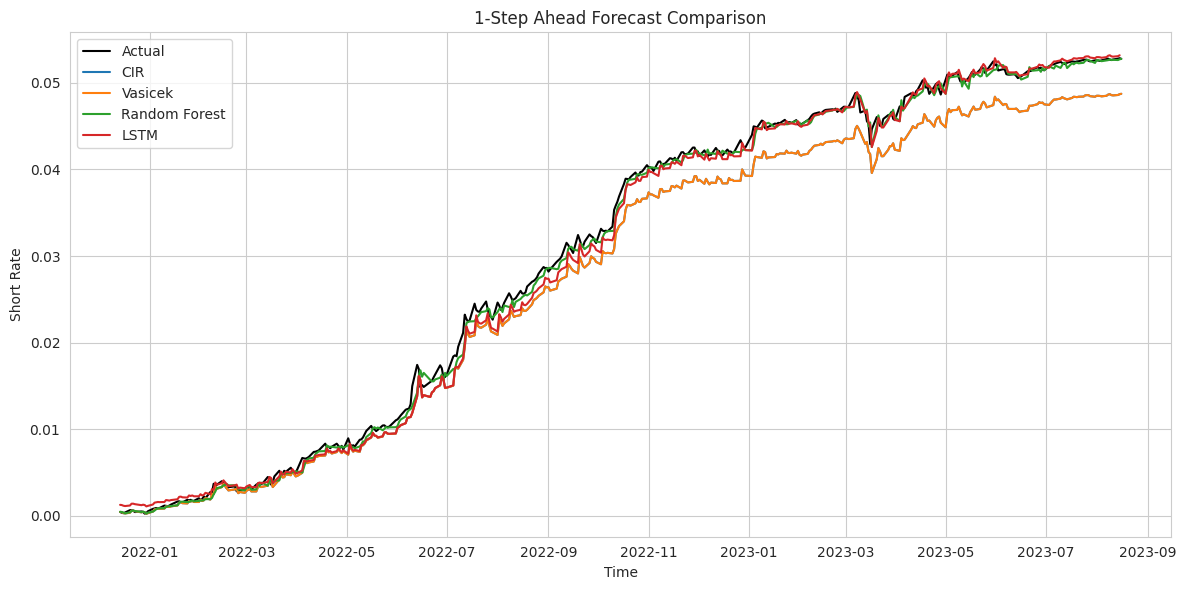

In [46]:

plt.figure(figsize=(12,6))
plt.plot(exact_rates.index, exact_rates['1 step exact'], label='Actual', color='black') # Access column using its label
plt.plot(pred_CIR.index, pred_CIR['1 step pred'], label='CIR') # Access column using its label
plt.plot(pred_VSK.index, pred_VSK['1 step pred'], label='Vasicek') # Access column using its label
plt.plot(pred_rf.index, pred_rf['1 step pred'], label='Random Forest') # Assuming pred_rf_df should be pred_rf and access column using its label
plt.plot(pred_LSTM.index, pred_LSTM['1 step pred'], label='LSTM') # Assuming pred_LSTM_df should be pred_LSTM and access column using its label
plt.legend()
plt.title('1-Step Ahead Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Short Rate')
plt.tight_layout()
plt.show()